# Week 1 Lab: next generation sequencing and mutation hunting

## Part 1
**Due: Monday 4/8/19 9am**

**Partner: ** (optional. You must both turn in the assignment. You must choose a different partner each week.)

Skills covered: basic UNIX navigation, intro to NGS, sequence alignment and variant calling, python plotting


### Intro
A patient arrives in your clinic with a rare disorder. You expect the condition is genetic (i.e. due to a mutation in her genome). However since the condition is not observed in any family members, you suspect it could be due to a *de novo* mutation that occurred in the germline (egg or sperm cells) of one of her parents.

To look for potential disease-causing mutations, you perform whole genome sequencing on the patient and her parents (which together we call a "trio").

This week, we will learn some key basics for processing next generation sequencing (NGS) data, including sequence alignment, variant calling, and standard file formats (FASTQ/BAM/VCF). For this week's assignment, many commands and template code are provided to you. In future labs, you'll be doing more of this set up on your own.

Today, we'll get familiar with the datasets and align our reads to the reference genome. Thursday, we'll dive deeper and go look for candidate mutations.

## 1. Inspect raw data manually

For this part, open up a separate window running a terminal where you can run the commands.

Before running any analysis, it's a good practice to look manually at the data to make sure all the files are what you think they are. First, you should look at the sequence files to verify the format is correct. You don’t want to open the entire files, you will just do a quick inspection of the first few reads. Use the `head` command to look at the first 20 lines in the first fastq file for the child genome (`NA12878_child_1.fq`)
your file (replace [file.format] with the actual file name). Recall from the prelab that the datafiles specific to this week's assignment can be found in the `/datasets/cs185s-sp19-public/week1` directory.

```shell
head -n 20 [file.format]
```

Take a look at each file. Each read has 4 lines of information, and then the next read starts on the
following line. The first line starts with the "@" symbol, and contains identifiers and information about
this read. The next line contains the actual sequence, then on line three there is a "+", which may
sometimes have the identifier and info repeated. 

Line 4 contains the quality string, where ASCII characters encode the quality score for each base.
The quality score ranges from 0 to about 40; the higher the number, the greater the confidence of the
base call. To get the actual quality score, you need to figure out the value of the symbol, then subtract
33 (this is called "Sanger" scaling type, because it's the same scaling that people use with traditional
sanger sequencing). With some older Illumina data (pre version 1.8), you subtract other numbers, like
64, for more info, see: 

http://drive5.com/usearch/manual/quality_score.html

Also take a look at the second file, containing the second read in each read pair. Notice the reads are in the same order in each file. e.g. the first reads in `NA12878_child_1.fq` and in `NA12878_child_2.fq` are paired. They have identical read identifiers, with the exception of the suffix `<read id>/1` vs. `<read id>/2`.

**Question 1 (2 pts)**: Look at the beginning of the `NA12878_child_1.fq` file, and find the third read. What is the read identifier? What is the quality symbol for the read's first base? Look up the value associated with this ASCII symbol online. What is the probability that this base is an error?

Command ran:<br>
head -n 12 NA12878_child_1.fq

Third read identifier: <br>
@HSQ1004:134:C0D8DACXX:1:1101:1529:183767/1


Quality Symbol for the read's first base: <br>
C

Probability that his base is an error (using modern ASCII_BASE 33): <br>
P_error = 0.00040 <br>
Q_score = 34


Now let's take a look at the human reference genome, which is stored in `/datasets/cs185s-sp19-public/genomes/hg19.fa`, and introduce a new UNIX command. We can use the `cat` command to print the contents of a file to the screen. 

The reference genome is a pretty big file (~3GB GB) so we don't want to look at the whole thing at once. Instead, we'll use a UNIX trick of "piping" (using the `|` symbol) which allows us to take the output of one command and use it as input to the next:

```
cat hg19.fa | head -n 10
```

This command first ran `cat` to print the file to the screen (which we call "standard output"). Then the command of `head` used the output of `cat` as its input rather than specifying a file directly as we did above. We refer to this as "standard input".

<blockquote>
**UNIX TIP**: If you accidently open (e.g. cat) a huge file and just see characters flying down your screen, matrix style, or if you think a process you are running may be stuck, you can press control+c to cancel the last command.
</blockquote>

We can string together a bunch of commands which can be pretty flexible. e.g. if you want look further down the file at lines 9990 through 10,000 you can do:

```
cat hg19.fa | head -n 10000 | tail -n 10
```

which prints the reference genome, takes the top (`head`) 10,000 lines, then the last (`tail`) 10 lines of that.

**Question 2 (1 pt)**: What is the name of the first chromosome listed in the reference genome? 

>chr1

**Question 3 (2 pts)**: Write a one-line UNIX command to print out the read ID of the 100th read (and nothing else) from the file `NA12878_child_1.fq`. (Hint: remember each read takes up 4 lines)

head -n 397 NA12878_child_1.fq | tail -n 1

We'll introduce one more helpful UNIX command before moving on. The tool `wc` includes a helpful option to count the number of lines in a file:

```
wc -l [filename]
```

<blockquote>
If you want more details about a UNIX tool, you can try looking at the manual using `man`, e.g. `man wc -l`
</blockquote>

**Question 4 (1 pt)**: Using `wc -l`, determine how many read pairs we have for each of the three samples (child, mother, and father)

Child read pairs = 208148/4 = 52037 <br>
Mother read pairs = 223596/4 = 55899 <br>
Father read pairs = 211088/4 = 52772 <br>


## 2.  Inspect raw sequencing data with fastqc

Make sure you run the cell above. Then, in the terminal, `cd` into your home directory. Make a new directory `week1`. Use `ls` to confirm the `week1` directory is there, and `cd` into it.

```
ls
cd week1
```

This is where you will be working for the rest of the week.

Now you are ready to run `fastqc`, a simple fastq statistics analysis program. First, make sure the program is working and properly installed by typing the command below. You should see the manual page. Please ask a TA if this is not working.

```
fastqc -h
```

Run the program fastqc on the fastq files. You will have to specify the path to the `/datasets/cs185s-sp19-public/week1` folder, since you should leave the files there. You also have to tell `fastqc` to `-o` output the files to the current directory, which you indicate with a `.` The command to do all this is below, but you have to specify the full root path to each fastq file.

```
fastqc -o . NA12878_child_1.fq NA12878_child_2.fq NA12891_father_1.fq NA12891_father_2.fq NA12892_mother_1.fq NA12892_mother_2.fq
```

Check with `ls` that this generated some files. The html files contain the whole report. You can view them by going to the notebook view (https://datahub.ucsd.edu/user/yourusername/tree), navigating to your week1 directory, and clicking on the files.

Open one of the files and take a look. Do the basic statistics match what you calculated for the number of reads? On the left, you’ll see a navigation window with green (normal), yellow (slightly abnormal), and red (very unusual) circles for several kinds of analyses. If you have any red circles, take note, and read the fastqc documentation on the analysis modules to try to learn what they mean.

http://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/

Our sequencing datasets are high quality and nothing should be flagged in red, indicating we're ready to move on to sequence alignment.

**Question 5 (3 pts)**: Look at the "Per base sequence quality" section of the `fastqc` output for one of the files. What happens to the quality scores as you get toward the end of the read? Propose an explanation for why. 

The quality score decreases towards the end of the read. In addition, the uncertanty or variability in the read increases and is weighted lower with the error bar expanding towards lower scores. The scores decrease towards the end of the sequence because of the build up of errors and contaminants in the process of detection.

## 3. Aligning sequences to the reference genome

To make sense out of these small sequences of DNA, we will map them to our reference sequence. Mapping works by taking each read and trying to find the closest matching sequence in the reference genome. 

There are many alignment programs ("aligners") available. The earliest alignment algorithms (Smith Waterman and Needleman-Wunsch) are still used today to compare small pieces of DNA one-by-one, but the computing power needed to map millions of short reads to genomes that are millions to billions of basepairs long requires special algorithms to speed up the process.

Today we will use an aligner called BWA-MEM, which makes use of the Burrows-Wheeler transform for reversible data compression (the reference is summarized with a special reversible index, the index makes it faster to search). BWA-MEM is optimized for ‘long’ next-generation sequencing reads of 100bp or more, which may contain several mutations, insertions, or deletions, as it works by finding the ‘maximum exact match’ within a read to the reference, rather than forcing the entire read to match.

First we need to index the reference file. This step takes a while, so **it has already been done for you**. We created the BWA-MEM index by running:

```
bwa index hg19.fa # don't run this!
```

This created several index files the program uses to rapidly search the genome. Do:
```
ls /datasets/cs185s-sp19-public/genomes/hg19.fa*
```

to see a list of those index files.

Now we're ready to perform the alignment. We'll first look at the usage message for the tool to see how to run it. Simply type the name of the command.

```
bwa mem
```

Note the line at the top that says: 
```
Usage: bwa mem [options] <idxbase> <in1.fq> [in2.fq]
```

This tells us what we need to run. The alignment command takes inputs in this order: first, specify the path to the fasta reference genome file used to create the index. Then specify the data files in fastq format. If the data is paired end, specify both of the fastq files. (Things in square brackets are optional.)

BWA MEM outputs alignments to standard output. We can use the `>` operator to redirect the output to a file. e.g.:

```
bwa mem [options] <idxbase> <file1.fq> <file2.fq> > output.sam
```

**Question 6 (5 pts)**: Based on the usage information above, align all three samples to the hg19 reference genome and output the alignments for each to a SAM file with an informative filename (e.g. NA12878_child.sam) in your home directory. Paste the commands you used to do this below.

bwa mem ../../../datasets/cs185s-sp19-public/genomes/hg19.fa ../../../datasets/cs185s-sp19-public/week1/NA12878_child_1.fq ../../../datasets/cs185s-sp19-public/week1/NA12878_child_2.fq > NA12878_child.sam

bwa mem ../../../datasets/cs185s-sp19-public/genomes/hg19.fa ../../../datasets/cs185s-sp19-public/week1/NA12891_father_1.fq ../../../datasets/cs185s-sp19-public/week1/NA12891_father_2.fq > NA12891_father.sam

bwa mem ../../../datasets/cs185s-sp19-public/genomes/hg19.fa ../../../datasets/cs185s-sp19-public/week1/NA12892_mother_1.fq ../../../datasets/cs185s-sp19-public/week1/NA12892_mother_2.fq > NA12892_mother.sam



**Alignment may take a few minutes, in the mean time, read about "sam":** BWA outputs data in the "SAM" format. We'll explore the data below, but to learn more about sam, check out: https://samtools.github.io/hts-specs/SAMv1.pdf

## 4. Meet SAM, inspect the alignment

Look at first five lines of the child alignment of your new sam file with head:

```
head -n 50 NA12878_child.sam
```

The first chunk of lines beginning with `@` are part of the header. After that comes the actual alignments.

Not all reads will be successfully aligned to the reference. The SAM file contains all reads, whether they successfully aligned or not. It's important to know what fraction of your reads aligned. If there are a lot reads that failed to align, that could indicate that your DNA was contaminated with some other source, or that something went wrong with the alignment.

In the SAM format, each line (after the headers) starts with a unique read ID in the first "field". Fields are delimited (separated) regions of data, similar to columns on a chart. Sam uses tabs as the delimiters. In later classes we will get into what some of the different fields mean (you should be able to recognize the quality string and the base string).

For now we are going to use the built in utilities of `samtools`, a program designed to read and parse sam files, to decode the samfile for us. Run the commands below to get some basis statistics.

```
samtools flagstat NA12878_child.sam
samtools flagstat NA12891_father.sam
samtools flagstat NA12892_mother.sam
```

Does the "in total" match the read count you computed earlier? You'll notice a slight discrepancy. Some reads will have multiple mappings (listed as secondary or supplementary) and for a couple reads only one read in the pair could be mapped. But the numbers should be pretty close.

**Question 7 (2 pts)**: What percentage of reads are mapped for each sample? 

Child: 99.81% <br>
Father: 99.91% <br>
Mother: 99.88% <br>

Next, you need to compress and sort the SAM files with the commands below. A compressed SAM file is called a BAM file. Like the reference, BAM files need to be indexed. This gets the data ready for some of the next commands we will use.

```
samtools view -S -b NA12878_child.sam > NA12878_child.bam
samtools sort NA12878_child.bam > NA12878_child.sorted.bam
samtools index NA12878_child.sorted.bam
```

The index command will generate a file `NA12878_child.sorted.bam.bai`. Use `ls` to check that it's there.

**Question 8 (3 pts)**: Using the above as a guide, generate sorted and indexed BAM files for each family member. Paste the commands you use do so below.

samtools view -S -b NA12878_child.sam > NA12878_child.bam <br>
samtools sort NA12878_child.bam > NA12878_child.sorted.bam <br>
samtools index NA12878_child.sorted.bam <br>

samtools view -S -b NA12891_father.sam > NA12891_father.bam <br>
samtools sort NA12891_father.bam > NA12891_father.sorted.bam <br>
samtools index NA12891_father.sorted.bam <br>

samtools view -S -b NA12892_mother.sam > NA12892_mother.bam <br>
samtools sort NA12892_mother.bam > NA12892_mother.sorted.bam <br>
samtools index NA12892_mother.sorted.bam <br>

Note, to view the contents of a BAM file, you cannot simply do something like `cat file.bam`, since it is a binary (not plaintext) file. Instead, use the samtools view command. e.g.:

```
samtools view NA12878_child.sorted.bam | head
```

If you want to view only a particular region, you can add a chromosome and position range to the command:

```
samtools view NA12878_child.sorted.bam chr6:128405804-128605805 # you might want to pipe this to head!
```

Note, viewing a specific region only works on BAM files that have been indexed.

## 5. Inspecting the template length distribution 

It is a good idea to do some basic quality checks on our BAM file.

Since our data is paired end, reads should be aligned in pairs, where each pair of reads aligns pretty close to each other. The distance between paired reads allows us to infer the size of the fragment that was sequenced. Here we will inspect the distribution of fragment lengths in our data.

First, we'll introduce a new UNIX command, `cut`. This command can extract different columns from a text file. e.g.:

```
cut -f 3,5 file.txt
```

will extract the 3rd and 5th columns of a tab-delimited file.

If you look back to the SAM specification, you'll see the 9th column gives the observed template length. This will be equal to 0 for reads that are not properly paired.

**Question 9 (3 pts)**: For the child genome, write and execute a one line UNIX command to extract a list of template lengths from the region chr6:128405804-128605805 to a file named `child_template_lengths.txt`. Hint: you can pipe together a `samtools view` and `cut` command and use `>` to direct output to a file. Paste your command below and give the first 5 values in the file.

samtools view NA12878_child.sorted.bam chr6:128405804-128605805 | cut -f 9 > child_template_lengths.txt

head child_template_lengths.txt -n 5

304

316

256

337

221

**Question 10 (5 pts)**: Finally, we'd like to visualize the distribution of template lengths. We can do this using python. Modify and run the code in the cell below to generate a histogram of template lengths and compute the median and median template lengths after removing 0's (indicating improperly paired reads). Hint, your histogram should have a bell curve shape and should not have any negative numbers.

Populating the interactive namespace from numpy and matplotlib
Mean template length: 317
Median template length: 317


(317.15144202814281, 317.0)

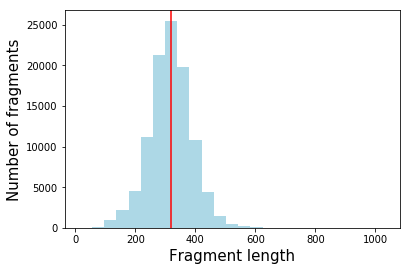

In [1]:
%pylab inline
import os
import numpy as np

# All output files will be stored in a week1 folder in your home directory
BASEDIR = os.path.join(os.environ["HOME"], "week1")

def PlotTlenDist(plot=False):
    median_tlen = 0
    mean_tlen = 0
    
    # Read template lengths into a list
    tlens = open(os.path.join(BASEDIR, "child_template_lengths.txt")).readlines()
    # Convert items in tlens list to integers
    tlens = [abs(int(item.strip())) for item in tlens]
    # Remove "0"
    tlens = [item for item in tlens if item > 0]
    
    # Compute median and mean of tlens below
    mean_tlen = np.mean(tlens)
    median_tlen = np.median(tlens)
    
    # Plot. See https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html
    print("Mean template length: %d"%mean_tlen)
    print("Median template length: %d"%median_tlen)

    if plot:
        plt.hist(tlens, bins=25, color="lightblue")
        plt.xlabel("Fragment length", size=15)
        plt.ylabel("Number of fragments", size=15);
        plt.axvline(x=mean_tlen, color="red");
        
    # Return stats 
    #return median_tlen, mean_tlen
    #^^^^^
    #I think this return order is wrong based off the function in the following cell
    return mean_tlen, median_tlen
    

PlotTlenDist(plot=True)

In [2]:
"""Check that PlotTlenDist function works"""
mean, median = PlotTlenDist(plot=False)

Mean template length: 317
Median template length: 317
